In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
!pip install pyarabic

In [ ]:
!pip install farasapy

In [ ]:
!git clone https://github.com/aub-mind/arabert

fatal: destination path 'arabert' already exists and is not an empty directory.


In [ ]:
!pip install demoji

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load Huggingface transformers
from transformers import TFBertModel,  BertConfig, BertTokenizerFast
from arabert.preprocess import ArabertPreprocessor

import pandas as p
import re
import demoji

# Then what you need from tensorflow.keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, Bidirectional, BatchNormalization, Attention, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal, GlorotUniform

from sklearn.metrics import f1_score

In [ ]:
def printHistory(history):
    for key in history.history:
        print(key, ': ', history.history[key][-1])

In [ ]:
def jaccardAccuracy(y_true, y_pred):
    #print('step 0')
    y_pred = tf.cast(y_pred + 0.5, tf.int32)
    y_true = tf.cast(y_true , tf.int32)
    #print('step 1')
    intersiction = tf.bitwise.bitwise_and(y_true, y_pred)
    union = tf.bitwise.bitwise_or(y_true, y_pred)
    #print('step 2')
    num_intersiction = tf.math.reduce_sum(intersiction, axis=1)
    num_intersiction = tf.cast(num_intersiction, dtype=tf.float32)
    num_union = tf.math.reduce_sum(union, axis=1)
    num_union = tf.cast(num_union, dtype=tf.float32)
    #print('step 3')

    result = tf.reduce_mean(tf.math.divide_no_nan(num_intersiction,num_union))
    return result

In [ ]:
def plotHistory(history, plot_type='loss', ylim = [0,1]):
    plt.plot(history.history[plot_type], label=plot_type)
    plt.plot(history.history['val_'+plot_type], label = 'val_'+plot_type)
    plt.xlabel('Epoch')
    plt.ylabel(plot_type)
    plt.ylim(ylim)
    plt.legend(loc='lower right')
    plt.title(plot_type + ' Graph')
    plt.show()

In [ ]:
def printEmotionAccuracy(y, y_pred, classes):
    for key in classes:
        accuracy = (y[:,classes[key]] == y_pred[:,classes[key]]).sum() / y.shape[0] * 100
        print(key, ': ', accuracy, '%')


In [ ]:
def printEmotionF1(y, y_pred, classes):
    for key in classes:
        f1 = f1_score(y[:,classes[key]], y_pred[:,classes[key]])
        print(key, ': ', f1*100, '%')


In [ ]:
def printJaccardAccuracy(y, y_pred):
    intersection = np.logical_and(y, y_pred).sum(-1)
    union = np.logical_or(y, y_pred).sum(-1)
    accuracy = ((intersection / union).sum()) / union.shape[0] * 100
    return accuracy


In [ ]:
def data_cleaning(data):
    line = ""
    lines = []
    demoji.download_codes()
    for index, row in data.iterrows():
        line = re.sub(r'#', '', str(row["tweet"]))
        line = re.sub(r'https?:\/\/.*[\r\n]*', 'URL', line)
        line = re.sub("@[A-Za-z0-9-_]+", "@USER",line)
        line = row["tweet"].replace('\r', ' ')
        line = row["tweet"].replace('\n', ' ')
        line = demoji.replace(line, "")
        lines.append(line)

    data["cleaned_tweet"] = lines
    del data['tweet']

    return data


In [ ]:
names = [ 'id','tweet','anger','anticipation', 'disgust','fear','joy','love','optimism','pessimism', 'sadness','surprise','trust']

data = p.read_csv("/content/drive/MyDrive/research/Emotion detection on arabic/SemEval2018-Task1-all-data/Arabic/E-c/2018-E-c-Ar-train.txt",
                  names = names ,
                  sep = '\t',
                  lineterminator= '\n',
                  header=0)
dev_data = p.read_csv("/content/drive/MyDrive/research/Emotion detection on arabic/SemEval2018-Task1-all-data/Arabic/E-c/2018-E-c-Ar-dev.txt",
                      names = names ,
                      sep = '\t',
                      lineterminator= '\n',
                      header=0)

data = data_cleaning(data)
dev_data = data_cleaning(dev_data)

... OK (Got response in 0.37 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
... OK (Got response in 0.36 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK


In [ ]:
num_sample = data.shape[0]
label_frequent = data.iloc[:,1:-1].sum().sort_values(ascending=False)
print('Number of Train Samples: ', num_sample)
print('Emotion Frequent on Train Samples')
print(label_frequent)

print('#################')
dev_num_sample = dev_data.shape[0]
dev_label_frequent = dev_data.iloc[:,1:-1].sum().sort_values(ascending=False)
print('Number of Valid Samples: ', dev_num_sample)
print('Emotion Frequent on Valid Samples')
print(dev_label_frequent)

Number of Train Samples:  2278
Emotion Frequent on Train Samples
anger           899
sadness         842
joy             605
love            562
optimism        561
pessimism       499
disgust         433
fear            391
anticipation    206
trust           120
surprise         47
dtype: int64
#################
Number of Valid Samples:  585
Emotion Frequent on Valid Samples
sadness         217
anger           215
joy             179
love            175
optimism        169
pessimism       125
disgust         106
fear             94
anticipation     57
trust            36
surprise         13
dtype: int64


In [ ]:
label_frequent.loc['anger']

899

In [ ]:
model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)

data['cleaned_tweet'] = data['cleaned_tweet'].apply(lambda x: arabert_prep.preprocess(x))

dev_data['cleaned_tweet'] = dev_data['cleaned_tweet'].apply(lambda x: arabert_prep.preprocess(x))

[2021-05-08 21:37:11,560 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
model_name = 'asafaya/bert-mini-arabic'
task_name = 'classification'

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = True

tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Some layers from the model checkpoint at asafaya/bert-mini-arabic were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at asafaya/bert-mini-arabic.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
print(config)

BertConfig {
  "_name_or_path": "asafaya/bert-mini-arabic",
  "_num_labels": 2,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.5.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}



In [ ]:
# Tokenize the input (takes some time)
max_length = max(len(x) for x in data['cleaned_tweet'].to_list())
x = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=data['cleaned_tweet'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

dev_x = tokenizer.batch_encode_plus(
    batch_text_or_text_pairs=dev_data['cleaned_tweet'].to_list(),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = False,
    verbose = True)

In [ ]:
classes = {
    'anger' : 0,
    'anticipation' : 1,
    'disgust' : 2,
    'fear' : 3,
    'joy' : 4,
    'love' : 5,
    'optimism' : 6,
    'pessimism' : 7,
    'sadness' : 8,
    'surprise' : 9,
    'trust' : 10,
}
y = np.zeros((data.shape[0], 11))
for key in classes:
    y[:,classes[key]] = data.loc[:, key].values

dev_y = np.zeros((dev_data.shape[0], 11))
for key in classes:
    dev_y[:,classes[key]] = dev_data.loc[:, key].values

# Use the last hidden state of BERT as word embbeding

In [ ]:
class_weights = {}
for key in classes:
    class_weights[classes[key]] = num_sample / (label_frequent.loc[key])
print(class_weights)

In [ ]:
# Load the MainLayer
bert = transformer_model.layers[0]
bert.trainable = False

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[0]
batch_normalization_1 =  BatchNormalization()(bert_model)

biLSTM = Bidirectional(LSTM(128, return_sequences=False), merge_mode='concat')(batch_normalization_1)
batch_normalization_2 = BatchNormalization()(biLSTM)

#biLSTM_2 = Bidirectional(LSTM(512, return_sequences=False), merge_mode='concat')(batch_normalization_2)
#batch_normalization_3 = BatchNormalization()(biLSTM_2)

dense = Dense(units=256, activation='tanh', kernel_initializer=TruncatedNormal(stddev=config.initializer_range))(batch_normalization_2)
batch_normalization_4 = BatchNormalization()(dense)

# Then build your model output
outputs = Dense(units=11,activation='sigmoid', kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='outputs')(batch_normalization_4)



# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')



# Take a look at the model
model.summary()

# Set an optimizer
optimizer = Adam(learning_rate=1e-03)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = [jaccardAccuracy])

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y=y,
    class_weight=class_weights,
    validation_data = ({'input_ids': dev_x['input_ids']},dev_y),
    batch_size=16,
    epochs=10)

In [ ]:
printHistory(history)

In [ ]:
plotHistory(history, plot_type='loss', ylim = [0,3])

In [ ]:
plotHistory(history, plot_type='jaccardAccuracy')

In [ ]:
y_pred = model.predict({'input_ids': x['input_ids']})
y_pred = y_pred >= 0.5
print('Emotion Train F1: ')
printEmotionF1(y, y_pred, classes)

print('###############')

dev_y_pred = model.predict({'input_ids': dev_x['input_ids']})
dev_y_pred = dev_y_pred >= 0.5
print('Emotion Valid F1: ')
printEmotionF1(dev_y, dev_y_pred, classes)


In [ ]:
printJaccardAccuracy(y, y_pred)

# Use the last hidden state of BERT as word embbeding with KLDivergence Loss

In [ ]:
def abs_KL_div(y_true, y_pred):
    y_true = tf.clip_by_value(y_true, tf.keras.backend.epsilon(), 100)
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 100)
    return tf.math.reduce_sum(tf.math.abs( (y_true- y_pred) * (tf.math.log(y_true / y_pred))), axis=-1)

In [ ]:
# Load the MainLayer
bert = transformer_model.layers[0]
bert.trainable = False

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[0]
batch_normalization_1 =  BatchNormalization()(bert_model)

biLSTM = Bidirectional(LSTM(512, return_sequences=False), merge_mode='concat')(batch_normalization_1)
batch_normalization_2 = BatchNormalization()(biLSTM)

#biLSTM_2 = Bidirectional(LSTM(512, return_sequences=False), merge_mode='concat')(batch_normalization_2)
#batch_normalization_3 = BatchNormalization()(biLSTM_2)

#dense = Dense(units=1024, activation='relu', kernel_initializer=TruncatedNormal(stddev=config.initializer_range))(batch_normalization_2)
#batch_normalization_4 = BatchNormalization()(dense)

# Then build your model output
outputs = Dense(units=11,activation='sigmoid', kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='outputs')(batch_normalization_2)



# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')



# Take a look at the model
model.summary()

# Set an optimizer
optimizer = Adam(learning_rate=5e-04)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = abs_KL_div,
    metrics = [jaccardAccuracy])

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y=y,
    validation_data = ({'input_ids': dev_x['input_ids']},dev_y),
    batch_size=32,
    epochs=10)

In [ ]:
printHistory(history)

In [ ]:
plotHistory(history, plot_type='loss', ylim=[0, 70])

In [ ]:
plotHistory(history, plot_type='jaccardAccuracy')

In [ ]:
y_pred = model.predict({'input_ids': x['input_ids']})
y_pred = y_pred >= 0.5
print('Emotion Train F1: ')
printEmotionF1(y, y_pred, classes)

print('###############')

dev_y_pred = model.predict({'input_ids': dev_x['input_ids']})
dev_y_pred = dev_y_pred >= 0.5
print('Emotion Valid F1: ')
printEmotionF1(dev_y, dev_y_pred, classes)


# Use second-to-last hidden state of BERT as word embedding

In [ ]:
# Load the MainLayer
bert = transformer_model.layers[0]
bert.trainable = False

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[2][-2]
batch_normalization_1 =  BatchNormalization()(bert_model)

biLSTM = Bidirectional(LSTM(512, return_sequences=False), merge_mode='concat')(batch_normalization_1)
batch_normalization_2 = BatchNormalization()(biLSTM)

#biLSTM_2 = Bidirectional(LSTM(512, return_sequences=False), merge_mode='concat')(batch_normalization_2)
#batch_normalization_3 = BatchNormalization()(biLSTM_2)

#dense = Dense(units=1024, activation='relu', kernel_initializer=TruncatedNormal(stddev=config.initializer_range))(batch_normalization_2)
#batch_normalization_4 = BatchNormalization()(dense)

# Then build your model output
outputs = Dense(units=11,activation='sigmoid', kernel_initializer=TruncatedNormal(stddev=config.initializer_range), name='outputs')(batch_normalization_2)



# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')



# Take a look at the model
model.summary()


In [ ]:
# Set an optimizer
optimizer = Adam(learning_rate=5e-05)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = [jaccardAccuracy])

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y=y,
    validation_data = ({'input_ids': dev_x['input_ids']},dev_y),
    batch_size=32,
    epochs=30)

In [ ]:
for key in history.history:
    print(key, ': ', history.history[key][-1])

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Loss Graph')
plt.show()

In [ ]:
plt.plot(history.history['jaccardAccuracy'], label='jaccardAccuracy')
plt.plot(history.history['val_jaccardAccuracy'], label = 'val_jaccardAccuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Jaccard Accuracy Graph')
plt.show()

# Attention

In [1]:
class AttentionWh(layers.Layer):
    def __init__(self, units=256, max_length=1):
        super(AttentionWh, self).__init__()
        w_init = tf.keras.initializers.GlorotUniform()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 1, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        #return tf.tile(self.w, [1,max_length,1])
        attention = tf.keras.layers.Attention()([tf.tile(self.w, [1,max_length,1]), inputs])
        #return tf.math.reduce_sum(attention, axis = 1)

        return attention

NameError: name 'layers' is not defined

In [ ]:
class_weights = {}
for key in classes:
    class_weights[classes[key]] = num_sample / (label_frequent.loc[key])
print(class_weights)

In [ ]:
# Load the MainLayer
bert = transformer_model.layers[0]
bert.trainable = False

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[0]
batch_normalization_1 =  BatchNormalization(name='Bert_normalization')(bert_model)

attention = AttentionWh(units = config.hidden_size, max_length=max_length)(batch_normalization_1)
batch_normalization_atention = BatchNormalization(name='Attention_normalization')(attention)

biLSTM = Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=False), merge_mode='concat')(batch_normalization_atention)
batch_normalization_2 = BatchNormalization()(biLSTM)
#biLSTM_dropout = Dropout(0.2, name='biLSTM_dropout')(batch_normalization_2)

#attention = AttentionWh(units = 2*512, max_length=max_length)(batch_normalization_2)
#batch_normalization_atention = BatchNormalization(name='Attention_normalization')(attention)

#biLSTM = Bidirectional(LSTM(512, return_sequences=False), merge_mode='concat')(attention)
#batch_normalization_2 = BatchNormalization()(biLSTM)

#biLSTM_2 = Bidirectional(LSTM(512, return_sequences=False), merge_mode='concat')(batch_normalization_2)
#batch_normalization_3 = BatchNormalization()(biLSTM_2)

dense = Dense(units=64, activation='relu', name='Dense')(batch_normalization_2)
batch_normalization_4 = BatchNormalization(name='Dense_normalization')(dense)
#dropout = Dropout(0.2, name='dropout')(batch_normalization_4)

# Then build your model output
outputs = Dense(units=11,activation='sigmoid',  name='outputs')(batch_normalization_4)



# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')



# Take a look at the model
model.summary()

# Set an optimizer
optimizer = Adam(learning_rate=1e-03)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = [jaccardAccuracy])

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y=y,
    validation_data = ({'input_ids': dev_x['input_ids']},dev_y),
    class_weight = class_weights,
    batch_size=256,
    epochs=192)

In [ ]:
printHistory(history)

In [ ]:
plotHistory(history, plot_type='loss', ylim=[0, 3])

In [ ]:
plotHistory(history, plot_type='jaccardAccuracy')

In [ ]:
y_pred = model.predict({'input_ids': x['input_ids']})
y_pred = y_pred >= 0.5
print('Emotion Train F1: ')
printEmotionF1(y, y_pred, classes)

print('###############')

dev_y_pred = model.predict({'input_ids': dev_x['input_ids']})
dev_y_pred = dev_y_pred >= 0.5
print('Emotion Valid F1: ')
printEmotionF1(dev_y, dev_y_pred, classes)


# Multi Attention

In [ ]:
class AttentionWh(layers.Layer):
    def __init__(self, units=256, max_length=1):
        super(AttentionWh, self).__init__()
        w_init = tf.keras.initializers.GlorotUniform()
        self.w = tf.Variable(
            initial_value=w_init(shape=(1, 1, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        #return tf.tile(self.w, [1,max_length,1])
        attention = tf.keras.layers.Attention()([tf.tile(self.w, [1,max_length,1]), inputs])
        #return tf.math.reduce_sum(attention, axis = 1)

        return attention

In [ ]:
class_weights = {}
for key in classes:
    class_weights[classes[key]] = num_sample / (label_frequent.loc[key])
print(class_weights)

{0: 2.5339265850945494, 1: 11.058252427184467, 2: 5.2609699769053115, 3: 5.826086956521739, 4: 3.765289256198347, 5: 4.05338078291815, 6: 4.0606060606060606, 7: 4.565130260521042, 8: 2.705463182897862, 9: 48.46808510638298, 10: 18.983333333333334}


In [ ]:
# Load the MainLayer
bert = transformer_model.layers[0]
bert.trainable = False

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = {'input_ids': input_ids}

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[0]
batch_normalization_1 =  BatchNormalization(name='Bert_normalization')(bert_model)

#Bidirectional GRU
#biGRU = Bidirectional(GRU(64, return_sequences=True), merge_mode='concat')(batch_normalization_1)
#batch_normalization_2 = BatchNormalization()(biGRU)
#biLSTM_dropout = Dropout(0.2, name='biLSTM_dropout')(batch_normalization_2)

#Attention on each emotion
batch_normalization_atention = []
for att in range(11):
  attention = AttentionWh(units = config.hidden_size, max_length=max_length)(batch_normalization_1)
  normalization = BatchNormalization(name='batch_normalization_atention_'+str(att))(attention)
  batch_normalization_atention.append(normalization)

#Bi GRU on each emotion
batch_normalization_GRU = []
for att in range(11):
  biGRU = Bidirectional(GRU(64, return_sequences=False), merge_mode='concat')(batch_normalization_atention[att])
  normalization = BatchNormalization(name='batch_normalization_GRU_'+str(att))(biGRU)
  batch_normalization_GRU.append(normalization)

#Dense layer on each emotion
batch_normalization_dense = []
for att in range(11):
  dense = Dense(units=256, activation='relu',  name='dense_'+str(att))(batch_normalization_GRU[att])
  normalization = BatchNormalization(name='batch_normalization_dense_'+str(att))(dense)
  batch_normalization_dense.append(normalization)


#output layer on each emotion
output = []
for att in range(11):
  out = Dense(units=1, activation='sigmoid',  name='output_'+str(att))(batch_normalization_dense[att])
  output.append(out)

#Final output layer
outputs = tf.keras.layers.Concatenate(name='outputs')(output)

# And combine it all in a model object
model = Model(inputs=inputs, outputs=outputs, name='BERT_MultiLabel_MultiClass')


# Take a look at the model
model.summary()

# Set an optimizer
optimizer = Adam(learning_rate=5e-03)

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = [jaccardAccuracy])

# Fit the model
history = model.fit(
    x={'input_ids': x['input_ids']},
    y=y,
    validation_data = ({'input_ids': dev_x['input_ids']},dev_y),
    class_weight = class_weights,
    batch_size=256,
    #epochs=192)
    epochs=60)

Model: "BERT_MultiLabel_MultiClass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 198)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 11548928    input_ids[0][0]                  
__________________________________________________________________________________________________
Bert_normalization (BatchNormal (None, 198, 256)     1024        bert[4][5]                       
__________________________________________________________________________________________________
attention_wh_44 (AttentionWh)   (None, 198, 256)     256         Bert_normalization[0][0]         
_________________________________________________________________________

In [ ]:
printHistory(history)

loss :  0.5505300760269165
jaccardAccuracy :  0.7666073441505432
val_loss :  0.4848020374774933
val_jaccardAccuracy :  0.3229770362377167


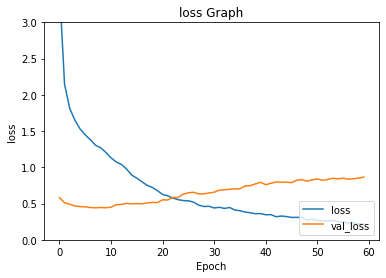

In [ ]:
plotHistory(history, plot_type='loss', ylim=[0, 3])

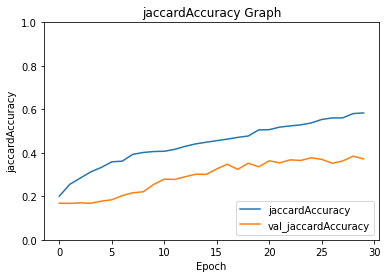

In [ ]:
plotHistory(history, plot_type='jaccardAccuracy')

In [ ]:
y_pred = model.predict({'input_ids': x['input_ids']})
y_pred = y_pred >= 0.5
print('Emotion Train F1: ')
printEmotionF1(y, y_pred, classes)

print('###############')

dev_y_pred = model.predict({'input_ids': dev_x['input_ids']})
dev_y_pred = dev_y_pred >= 0.5
print('Emotion Valid F1: ')
printEmotionF1(dev_y, dev_y_pred, classes)


Emotion Train F1: 
anger :  91.87319884726224 %
anticipation :  64.02640264026402 %
disgust :  90.54224464060529 %
fear :  91.86206896551725 %
joy :  95.35080304311073 %
love :  94.4922547332186 %
optimism :  92.10754553339115 %
pessimism :  67.98418972332017 %
sadness :  93.58128374325135 %
surprise :  88.0952380952381 %
trust :  85.71428571428571 %
###############
Emotion Valid F1: 
anger :  62.679425837320565 %
anticipation :  0.0 %
disgust :  24.113475177304963 %
fear :  44.5945945945946 %
joy :  62.30529595015576 %
love :  62.06896551724138 %
optimism :  57.14285714285715 %
pessimism :  11.188811188811187 %
sadness :  51.85185185185185 %
surprise :  14.285714285714288 %
trust :  0.0 %


In [ ]:
tweets = model.predict({'input_ids': x['input_ids']})
dev_tweets = model.predict({'input_ids': dev_x['input_ids']})

In [ ]:
svm = SVC(decision_function_shape='ovo')
svm = svm.fit(tweets, y, verbose=True)

NameError: ignored

In [ ]:
from sklearn.svm import SVC
emotion_svm = []
for k in range(11):
  svm = SVC()
  svm = svm.fit(tweets, y[:, k], verbose=True)
  emotion_svm.append(svm)



[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

In [ ]:
y_pred = np.zeros(y.shape)
for k in range(11):
  print(emotion_svm[k].predict(tweets).sum())


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
y_pred.shape

(2278, 11)

In [ ]:
y

In [ ]:
printJaccardAccuracy(y, y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


nan

In [ ]:
y_pred = model.predict({'input_ids': x['input_ids']})
y_pred = y_pred >= 0.5
print('Emotion Train F1: ')
printEmotionF1(y, y_pred, classes)

print('###############')

dev_y_pred = model.predict({'input_ids': dev_x['input_ids']})
dev_y_pred = dev_y_pred >= 0.5
print('Emotion Valid F1: ')
printEmotionF1(dev_y, dev_y_pred, classes)
